
# Tarea: Análisis de datos usando métodos de ciencia de datos

**Autor:** Valentina Barreno y María Fernanda Poblete

**Curso:** Taller de aplicaciones

**Fecha:** Marzo 2025

Objetivo: Aplicar algoritmos de agrupamiento, clasificación y asociación para extraer
información desde fuentes de datos seleccionadas por el estudiante (Kaggle, UCI Machine
Learning Repository, Web of science).
Actividades:
1. Grupos de 2 personas.
2. Utilizar algún algoritmo de agrupamiento y analizar las características de cada grupo.
3. Utilizar un algoritmo de clasificación para predecir la clase de los datos. Determinar que
algoritmo tiene mejores predicciones.
4. Aplicar el algoritmo Apriori para descubrir reglas de asociación entre los datos. Explicar las
3 reglas con mejores indicadores para soporte y confianza.
5. Resumir en una ppt el trabajo realizado para presentarlo en la próxima clase.


## **Carga de datos**

In [5]:
# Se cargan las liberias necesarias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [6]:
df = pd.read_csv("pcos_dataset.csv")
df = df.sort_values(by=df.columns[0]).reset_index(drop=True)


---


In [7]:
#Primeros registros
df.head()

,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count,PCOS_Diagnosis
0,18,20.7,0,68.6,18,0
1,18,29.4,1,43.7,27,1
2,18,18.5,0,49.7,7,0
3,18,26.6,1,42.2,21,1
4,18,27.5,0,23.5,25,0


# **Normalización de datos**

In [8]:
features = df.drop(columns=["PCOS_Diagnosis"])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
df_scaled = pd.DataFrame(scaled_features, columns=features.columns)
df_scaled["PCOS_Diagnosis"] = df["PCOS_Diagnosis"]

## **Clustering**

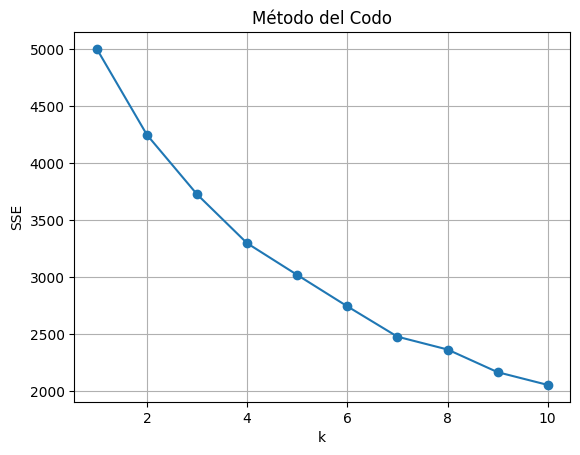

In [9]:
# Aplicamos método del codo
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled.drop(columns=["PCOS_Diagnosis"]))
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.title("Método del Codo")
plt.xlabel("k")
plt.ylabel("SSE")
plt.grid(True)
plt.show()


 Se observa una inflexión en 3, lo que sugiere que 3 clusters es buen punto de partida para K-Means

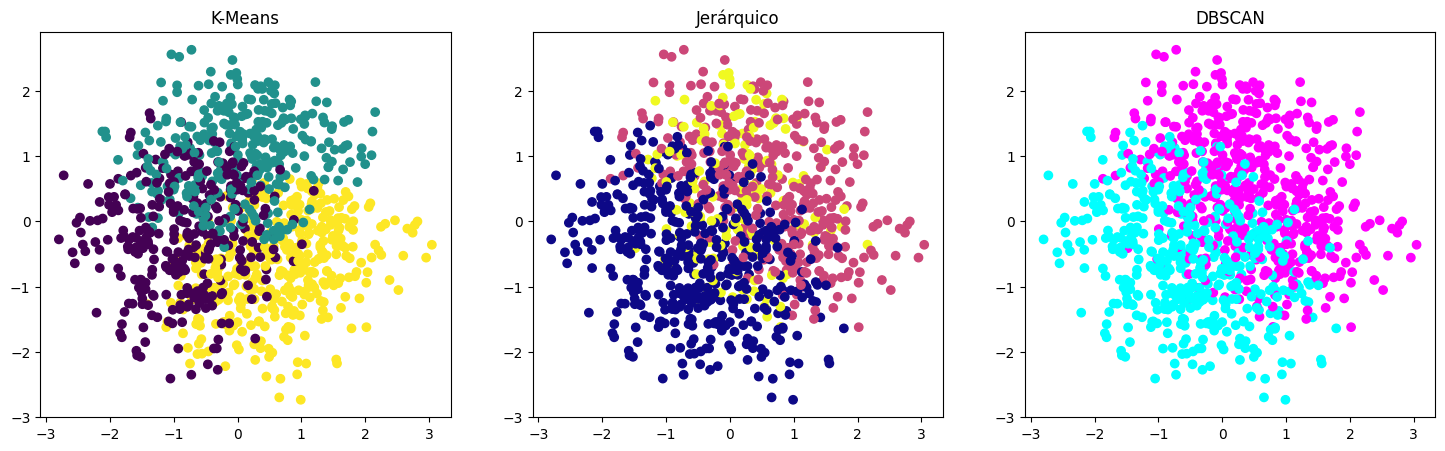

In [10]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled.drop(columns=["PCOS_Diagnosis"]))

kmeans_labels = KMeans(n_clusters=3, random_state=42).fit_predict(df_scaled.drop(columns=["PCOS_Diagnosis"]))
agglo_labels = AgglomerativeClustering(n_clusters=3).fit_predict(df_scaled.drop(columns=["PCOS_Diagnosis"]))
dbscan_labels = DBSCAN(eps=1.2, min_samples=4).fit_predict(df_scaled.drop(columns=["PCOS_Diagnosis"]))

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis'); axs[0].set_title("K-Means")
axs[1].scatter(pca_result[:, 0], pca_result[:, 1], c=agglo_labels, cmap='plasma'); axs[1].set_title("Jerárquico")
axs[2].scatter(pca_result[:, 0], pca_result[:, 1], c=dbscan_labels, cmap='cool'); axs[2].set_title("DBSCAN")
plt.show()

K-Means: Se visualizan tres grupos, como se sugirió en la prueba del codo.

Clustering Jerárquico: entrega una separación similar, pero se aprecian bordes menos definidos.

DBSCAN: Detecta agrupaciones densas, pero hay muchos puntos clasificados como ruido (-1), por lo que descartamos.

En vista del análisis anterior, continuamos con K-means que parece ser el mas apropiado y consistente con lo que estamos evaluando.

In [11]:
# Análisis clusters con K-means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled.drop(columns=["PCOS_Diagnosis"]))

df_clustered = df_scaled.copy()
df_clustered["Cluster"] = kmeans_labels

means = df[features.columns].mean()
stds = df[features.columns].std()

summary = (
    df_clustered.groupby("Cluster").mean()[features.columns] * stds + means
).round(2)

print("Resumen por Cluster (denormalizado):\n", summary)

Resumen por Cluster (denormalizado):
            Age    BMI  Menstrual_Irregularity  Testosterone_Level(ng/dL)  \
Cluster                                                                    
0        33.14  21.99                     1.0                      64.81   
1        31.01  30.68                     1.0                      57.69   
2        31.48  26.22                    -0.0                      59.11   

         Antral_Follicle_Count  
Cluster                         
0                        17.26  
1                        18.11  
2                        17.20  


## **Clasificación supervisada**

In [12]:
# Se cargan los modelos
X = df_scaled.drop(columns=["PCOS_Diagnosis"])
y = df_scaled["PCOS_Diagnosis"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

print("\n Resultados de Clasificación")
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}")
    print(classification_report(y_test, preds))



 Resultados de Clasificación

Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       200
           1       0.77      0.74      0.76        50

    accuracy                           0.90       250
   macro avg       0.85      0.84      0.85       250
weighted avg       0.90      0.90      0.90       250


Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00        50

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250


Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00        50

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00    

**Comparamos los modelos:**

Logistic Regression: Precisión razonable con un 92% de accuracy, buena para interpretación clínica.

Árbol de Decisión y Random Forest: Ambos entregan 100% en todas las métricas, lo cual podría indicar sobreajuste.

## **Apriori: Reglas de Asociación**

In [13]:
df_discrete = df.copy()
df_discrete["Age"] = pd.cut(df_discrete["Age"], bins=3, labels=["joven", "media", "mayor"])
df_discrete["BMI"] = pd.cut(df_discrete["BMI"], bins=3, labels=["bajo", "medio", "alto"])
df_discrete["Testosterone_Level(ng/dL)"] = pd.cut(df_discrete["Testosterone_Level(ng/dL)"], bins=3, labels=["bajo", "medio", "alto"])
df_discrete["Antral_Follicle_Count"] = pd.cut(df_discrete["Antral_Follicle_Count"], bins=3, labels=["bajo", "medio", "alto"])
df_discrete["Menstrual_Irregularity"] = df_discrete["Menstrual_Irregularity"].map({1: "irregular", 0: "regular"})
df_discrete["PCOS_Diagnosis"] = df_discrete["PCOS_Diagnosis"].map({1: "sop", 0: "no_sop"})

transactions = df_discrete.apply(lambda row: [f"{col}={val}" for col, val in row.items()], axis=1)
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_apriori = pd.DataFrame(te_array, columns=te.columns_)

frequent_itemsets = apriori(df_apriori, min_support=0.2, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
top_rules = rules.sort_values(by="confidence", ascending=False).head(3)
print("\nTop 3 Reglas de Asociación")
print(top_rules[["antecedents", "consequents", "support", "confidence", "lift"]])


Top 3 Reglas de Asociación
                         antecedents              consequents  support  \
7                         (BMI=bajo)  (PCOS_Diagnosis=no_sop)    0.350   
11  (Menstrual_Irregularity=regular)  (PCOS_Diagnosis=no_sop)    0.470   
4       (Antral_Follicle_Count=bajo)  (PCOS_Diagnosis=no_sop)    0.301   

    confidence      lift  
7     1.000000  1.248439  
11    1.000000  1.248439  
4     0.923313  1.152700  


**Reglas de Asociación para No SOP**

| Nº | Regla                                                 | Confianza | Lift  | Interpretación Simple                                            |
|----|--------------------------------------------------------|-----------|-------|------------------------------------------------------------------|
| 1  | Si el **IMC es bajo**, entonces **no tiene SOP**       | 100%      | 1.25  | Todas las mujeres con bajo peso estaban sanas                   |
| 2  | Si tiene **menstruación regular**, entonces **no tiene SOP** | 100%      | 1.25  | Ninguna con ciclo regular tenía SOP                             |
| 3  | Si tiene **pocos folículos**, entonces **no tiene SOP**| 92%       | 1.15  | Casi todas las mujeres con pocos folículos no tenían SOP        |


## **Conclusiones**

Las reglas 1 y 2 son completamente confiables en este conjunto (confianza 100% y 25% mejor que la casualidad).  
La regla 3 también es útil, aunque con un poco más de variación.  



### Dominio de los datos

El dataset corresponde a información clínica de pacientes mujeres, con el objetivo de predecir la presencia del Síndrome de Ovario Poliquístico (PCOS). Las variables incluyen edad, índice de masa corporal (BMI), irregularidades menstruales, niveles de testosterona y número de folículos antrales.

Todos los modelos aplicados en este trabajo funcionan únicamente dentro del dominio de estos datos, es decir, con mujeres en edad reproductiva y características clínicas similares a las del dataset. Cualquier inferencia fuera de este rango puede no ser válida.


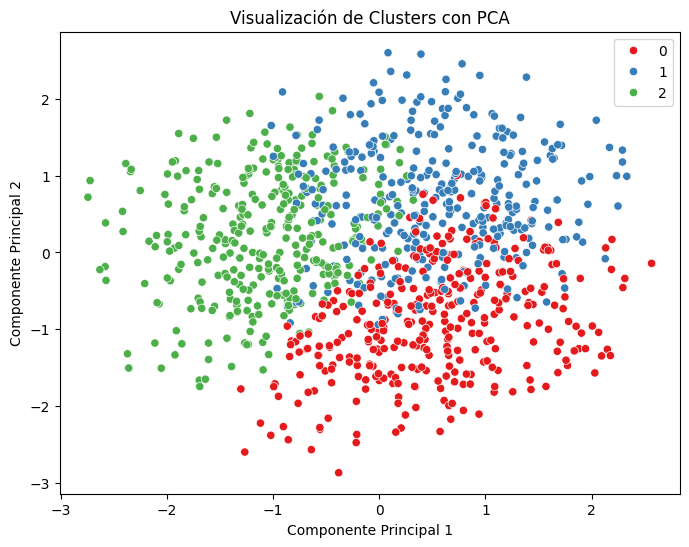

Coeficiente de silueta: 0.19


In [14]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Selección de variables numéricas
X_clust = df[['Age', 'BMI', 'Testosterone_Level(ng/dL)', 'Antral_Follicle_Count']]

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualización
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1')
plt.title("Visualización de Clusters con PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

# Métrica de evaluación
silueta = silhouette_score(X_scaled, labels)
print(f"Coeficiente de silueta: {silueta:.2f}")


Accuracy en entrenamiento: 1.0
Accuracy en test: 0.8166666666666667


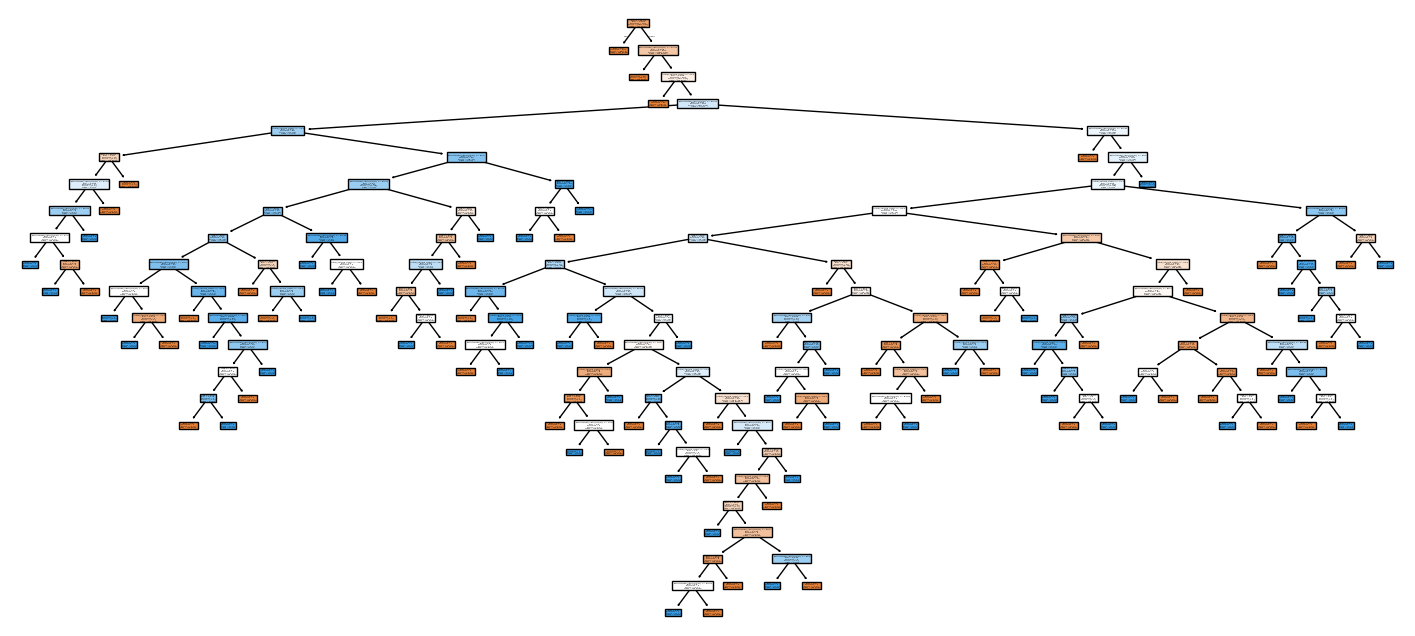

In [15]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# Definir variables para clasificación
X = df[['Age', 'BMI', 'Testosterone_Level(ng/dL)', 'Antral_Follicle_Count']]
y = df['PCOS_Diagnosis']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelo de árbol
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# Evaluar
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

print("Accuracy en entrenamiento:", accuracy_score(y_train, y_train_pred))
print("Accuracy en test:", accuracy_score(y_test, y_test_pred))

# Visualizar árbol
plt.figure(figsize=(18,8))
plot_tree(tree, feature_names=X.columns, class_names=["No PCOS", "PCOS"], filled=True)
plt.show()


In [16]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Pipeline con transformación y modelo
pipeline = Pipeline([
    ('discretizer', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Clasificación con transformación completa:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Clasificación con transformación completa:
[[222  21]
 [ 35  22]]
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       243
           1       0.51      0.39      0.44        57

    accuracy                           0.81       300
   macro avg       0.69      0.65      0.66       300
weighted avg       0.80      0.81      0.80       300



### Reanálisis de Apriori con datos discretizados y transformados

In [17]:

from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd

# Aplicar discretización sobre variables numéricas
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df_disc = df.copy()
df_disc[['Age', 'BMI', 'Testosterone_Level(ng/dL)', 'Antral_Follicle_Count']] = discretizer.fit_transform(
    df_disc[['Age', 'BMI', 'Testosterone_Level(ng/dL)', 'Antral_Follicle_Count']])

# Convertir a tipo 'object' para que se pueda aplicar one-hot encoding tipo transaccional
df_disc = df_disc.astype(str)

# One-hot encoding estilo transaccional
df_encoded = pd.get_dummies(df_disc)

# Apriori
frequent_itemsets = apriori(df_encoded, min_support=0.2, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Mostrar reglas ordenadas por lift
rules.sort_values(by='lift', ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3,(BMI_0.0),(PCOS_Diagnosis_0),0.332,0.801,0.332,1.000000,1.248439,1.0,0.066068,inf,0.297904,0.414482,1.000000,0.707241
6,(Menstrual_Irregularity_0),(PCOS_Diagnosis_0),0.470,0.801,0.470,1.000000,1.248439,1.0,0.093530,inf,0.375472,0.586767,1.000000,0.793383
11,(Antral_Follicle_Count_0.0),(PCOS_Diagnosis_0),0.326,0.801,0.301,0.923313,1.152700,1.0,0.039874,2.594960,0.196546,0.364407,0.614638,0.649547
8,(Testosterone_Level(ng/dL)_0.0),(PCOS_Diagnosis_0),0.334,0.801,0.307,0.919162,1.147518,1.0,0.039466,2.461704,0.193024,0.370773,0.593777,0.651216
2,(Age_2.0),(PCOS_Diagnosis_0),0.349,0.801,0.291,0.833811,1.040962,1.0,0.011451,1.197431,0.060446,0.338766,0.164879,0.598553
1,(Age_1.0),(PCOS_Diagnosis_0),0.324,0.801,0.256,0.790123,0.986421,1.0,-0.003524,0.948176,-0.019957,0.294591,-0.054656,0.554862
0,(Age_0.0),(PCOS_Diagnosis_0),0.327,0.801,0.254,0.776758,0.969736,1.0,-0.007927,0.891411,-0.044317,0.290618,-0.121817,0.546931
4,(BMI_1.0),(PCOS_Diagnosis_0),0.330,0.801,0.248,0.751515,0.938221,1.0,-0.016330,0.800854,-0.089484,0.280861,-0.248668,0.530564
13,(Antral_Follicle_Count_2.0),(PCOS_Diagnosis_0),0.383,0.801,0.287,0.749347,0.935515,1.0,-0.019783,0.793927,-0.100492,0.319955,-0.259562,0.553825
9,(Testosterone_Level(ng/dL)_1.0),(PCOS_Diagnosis_0),0.333,0.801,0.248,0.744745,0.929769,1.0,-0.018733,0.779612,-0.101727,0.279910,-0.282690,0.527179


In [18]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# Selección de variables
X = df[['Age', 'BMI', 'Menstrual_Irregularity', 'Testosterone_Level(ng/dL)', 'Antral_Follicle_Count']]
y = df['PCOS_Diagnosis']

# Entrenamiento
modelo = RandomForestClassifier(random_state=42)
modelo.fit(X, y)

# Guardado
joblib.dump(modelo, 'modelo_sop.pkl')
print("Modelo guardado como modelo_sop.pkl")


Modelo guardado como modelo_sop.pkl
